In [7]:
%matplotlib notebook

In [8]:
import matplotlib.pyplot as plt
import xtrack as xt

# Import MAD-X sequence to Xsuite

In [12]:
# Read MAD-X sequence from file (using cpymad)
from cpymad.madx import Madx
mad = Madx()
mad.option(echo=False)
mad.call('PIMM.seq')
mad.beam()
mad.use('pimms')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.00  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.05.05               +
  + Execution date: 2024.02.06 09:18:49      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [13]:
# Import in Xsuite
line = xt.Line.from_madx_sequence(mad.sequence.pimms,
                                  deferred_expressions=True)

Converting sequence "pimms":   0%|          | 0/96 [00:00<?, ?it/s]

# Inspect machine layout

In [19]:
# Compute survey
sv = line.survey()

<IPython.core.display.Javascript object>


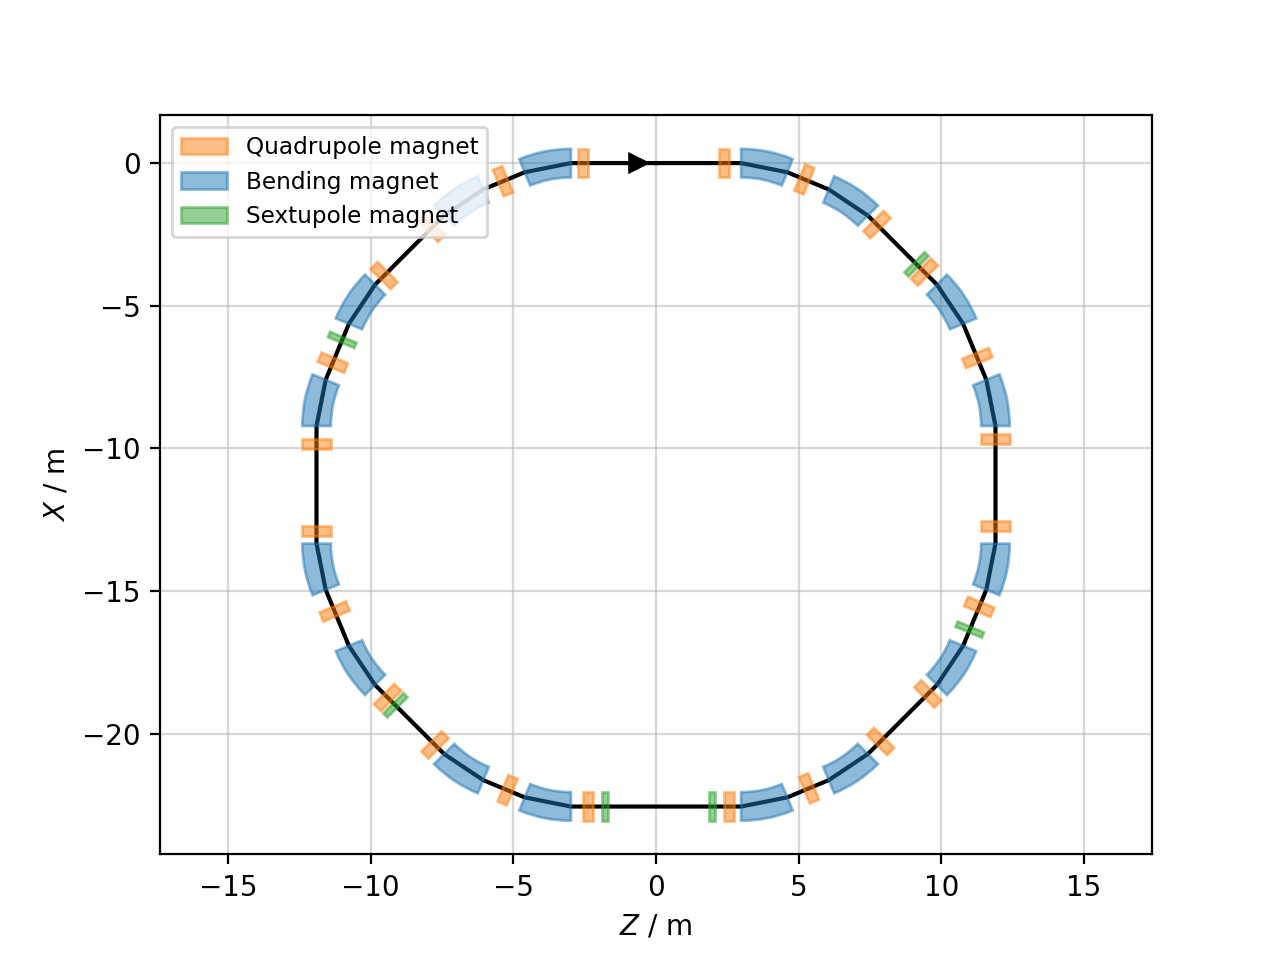

In [36]:
# Plot ring geometry using Xplt (credits P. Niedermayer)
import xplt
xplt.FloorPlot(sv, line)
plt.legend(fontsize='small', loc='upper left')

# Define reference particle

In [ ]:
line.particle_ref = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV,
                                 kinetic_energy0=200e6) # eV

# Match the optics

In [53]:
line.vars['kqf'] = 2e-2
line.vars['kqd'] = -2e-2

In [54]:
tw0 = line.twiss(method='4d')

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


In [55]:
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.Vary('kqf', limits=(0, 1),  step=1e-3),
        xt.Vary('kqd', limits=(-1, 0), step=1e-3),
        xt.VaryList(['ksf', 'ksd'], step=1e-3),
        
    ],
    targets=[
        xt.TargetSet(qx=1.6, qy=1.72, tol=1e-6, tag='tunes'),
        xt.TargetSet(dqx=-0.1, dqy=-0.1, tol=1e-3, tag="chrom"),
    ]
)


In [56]:
opt.target_status()
opt.step(20)
opt.target_status()

Target status:                  
id state tag   tol_met    residue current_val target_val description                         
 0 ON    tunes   False   -1.27175    0.328247        1.6 'qx', val=1.6, tol=1e-06, weight=10 
 1 ON    tunes   False -0.0259468     1.69405       1.72 'qy', val=1.72, tol=1e-06, weight=10
 2 ON    chrom   False    5.83945     5.73945       -0.1 'dqx', val=-0.1, tol=0.001, weight=1
 3 ON    chrom   False    7.19203     7.09203       -0.1 'dqy', val=-0.1, tol=0.001, weight=1
Target status:                   
id state tag   tol_met      residue current_val target_val description                         
 0 ON    tunes    True  1.39215e-09         1.6        1.6 'qx', val=1.6, tol=1e-06, weight=10 
 1 ON    tunes    True  7.23001e-10        1.72       1.72 'qy', val=1.72, tol=1e-06, weight=10
 2 ON    chrom    True -4.22809e-07        -0.1       -0.1 'dqx', val=-0.1, tol=0.001, weight=1
 3 ON    chrom    True -2.01579e-08        -0.1       -0.1 'dqy', val=-0.1, tol

In [59]:
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['kqf1', 'kqf2'], limits=(0, 1),  step=1e-3, tag='qf'),
        xt.Vary('kqd', limits=(-1, 0), step=1e-3, tag='qd'),
        xt.VaryList(['ksf', 'ksd'], step=1e-3),
        
    ],
    targets=[
        xt.TargetSet(qx=1.66, qy=1.72, tol=1e-6),
        xt.TargetSet(dqx=-0.1, dqy=-0.1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='es_septum', tol=1e-6)
    ]
)
opt.step(20)

In [60]:
opt.target_status()

Target status:                   
id state tag   tol_met      residue current_val target_val description                                 
 0 ON             True -8.33442e-10        1.66       1.66 'qx', val=1.66, tol=1e-06, weight=10        
 1 ON             True -8.68128e-12        1.72       1.72 'qy', val=1.72, tol=1e-06, weight=10        
 2 ON    chrom    True  8.30796e-08  -0.0999999       -0.1 'dqx', val=-0.1, tol=0.001, weight=1        
 3 ON    chrom    True -2.02126e-09        -0.1       -0.1 'dqy', val=-0.1, tol=0.001, weight=1        
 4 ON             True  1.58745e-09 1.58745e-09          0 ('dx', 'es_septum'), val=0, tol=1e-06, w ...


In [61]:
opt.vary_status()

Vary status:                 
id state tag name lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON    qf  kqf1           0    0.310793           1       0.28646 0.001      1
 1 ON    qf  kqf2           0    0.524738           1      0.520847 0.001      1
 2 ON    qd  kqd           -1   -0.523333           0      -0.51041 0.001      1
 3 ON        ksf         None    -1.00711        None     -0.821413 0.001      1
 4 ON        ksd         None    0.694637        None      0.324252 0.001      1


<IPython.core.display.Javascript object>


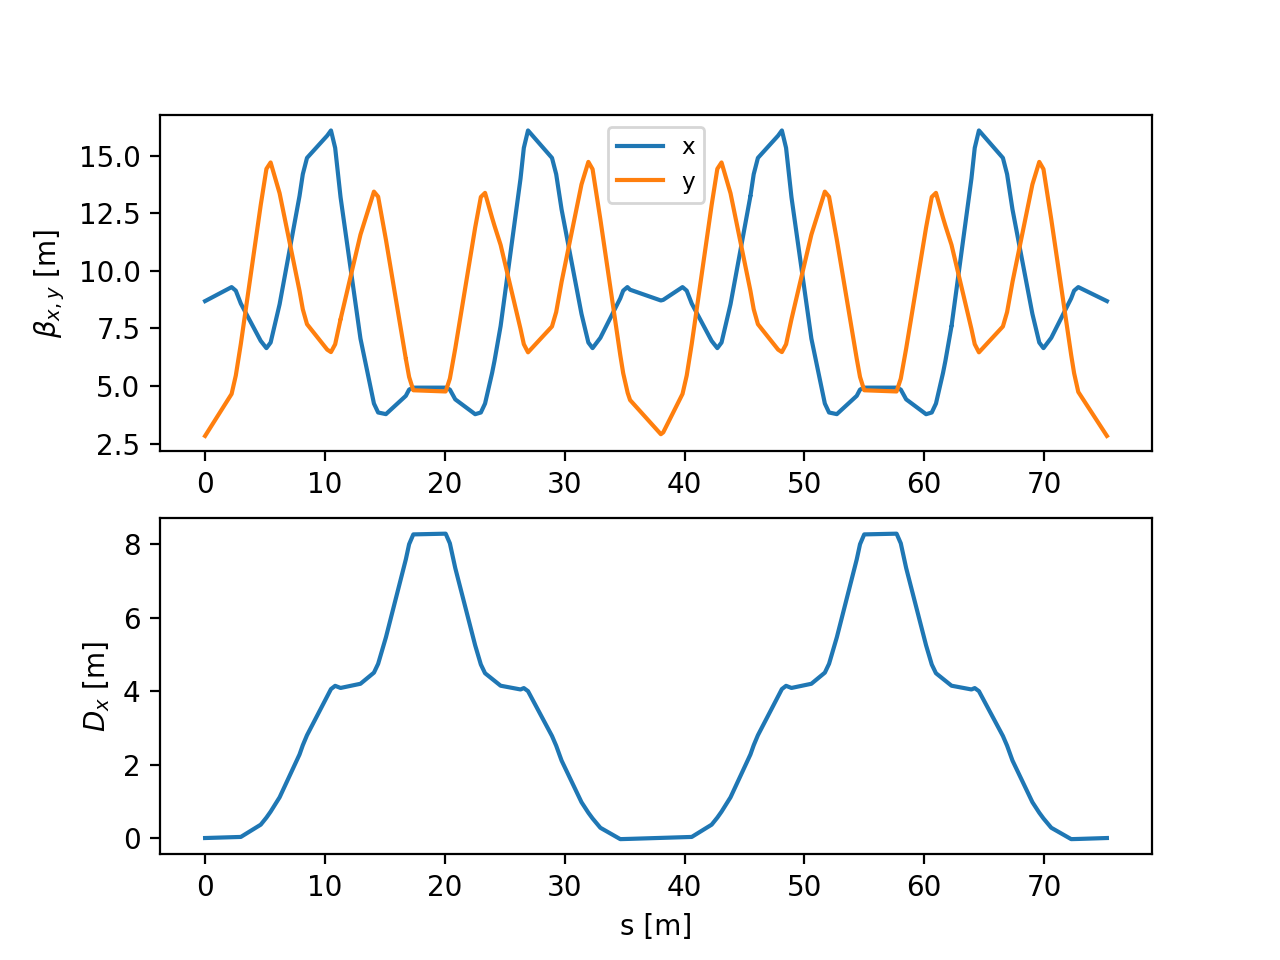

Text(0.5, 0, 's [m]')

In [62]:
tw = line.twiss(method='4d')

plt.figure(3)
ax1 = plt.subplot(2, 1, 1)
plt.plot(tw.s, tw.betx, '-', label='x')
plt.plot(tw.s, tw.bety, '-', label='y')
plt.ylabel(r'$\beta_{x,y}$ [m]')
plt.legend(fontsize='small')

plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(tw.s, tw.dx, '-', label='x')
plt.ylabel(r'$D_x$ [m]')
plt.xlabel('s [m]')

In [63]:
line.to_json('pimms_00_optics.json')